In [1]:
using Plots; pyplot()
using Distributions
using AugmentedGaussianProcesses
using KernelFunctions

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1278
┌ Info: Precompiling AugmentedGaussianProcesses [38eea1fd-7d7d-5162-9d08-f89d0f2e271e]
└ @ Base loading.jl:1278
┌ Warning: CUDA.jl found cuda, but did not find libcudnn. Some functionality will not be available.
└ @ Flux ~/.julia/packages/Flux/IjMZL/src/Flux.jl:56
┌ Warning: CUDA.jl found cuda, but did not find libcudnn. Some functionality will not be available.
└ @ Flux /home/theo/.julia/packages/Flux/IjMZL/src/Flux.jl:56


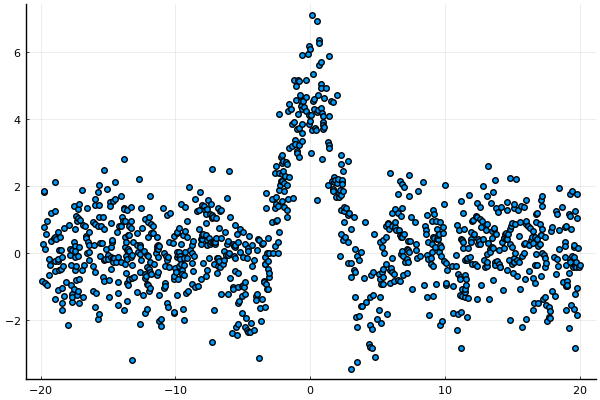

In [2]:
N = 1000
X = reshape((sort(rand(N)).-0.5).*40.0,N,1)
function latent(x)
    5.0.*sin.(x)./x
end
Y = (latent(X)+randn(N))[:];
scatter(X,Y,lab="")

In [4]:
# Run sparse classification with increasing number of inducing points
Ms = [4, 8, 16, 32, 64]
models = Vector{AbstractGP}(undef,length(Ms)+1)
kernel = PeriodicKernel(; r=[1.0])
for (index, num_inducing) in enumerate(Ms)
    @info "Training with $(num_inducing) points"
    m = SVGP(X, vec(Y), kernel,GaussianLikelihood(),AnalyticVI(),num_inducing)
    @time train!(m,100)
    models[index]=m;
end

┌ Info: Training with 4 points
└ @ Main In[4]:6


LoadError: MethodError: no method matching _evaluate(::KernelFunctions.Sinus{Float64}, ::SubArray{Float64,1,Array{Float64,2},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},true}, ::LinearAlgebra.Adjoint{Float64,SubArray{Float64,1,Array{Float64,2},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},true}})
Closest candidates are:
  _evaluate(!Matched::Union{Distances.UnionMetric, Distances.UnionPreMetric, Distances.UnionSemiMetric}, ::AbstractArray, ::AbstractArray) at /home/theo/.julia/packages/Distances/mNZEh/src/metrics.jl:223
  _evaluate(!Matched::Union{Distances.UnionMetric, Distances.UnionPreMetric, Distances.UnionSemiMetric}, ::AbstractArray, ::AbstractArray, !Matched::Nothing) at /home/theo/.julia/packages/Distances/mNZEh/src/metrics.jl:230
  _evaluate(!Matched::Union{Distances.UnionMetric, Distances.UnionPreMetric, Distances.UnionSemiMetric}, ::AbstractArray, ::AbstractArray, !Matched::AbstractArray) at /home/theo/.julia/packages/Distances/mNZEh/src/metrics.jl:256
  ...

In [16]:
@info "Training with full model"
mfull = GP(X, vec(Y), kernel,opt_noise=false)
@time train!(mfull,5);
models[end]=mfull;

┌ Info: Training with full model
└ @ Main In[16]:1


  0.316432 seconds (4.38 k allocations: 213.969 MiB, 40.07% gc time)


In [17]:
function compute_Grid(model,nGrid=50)
    mins = -20
    maxs = 20
    Xplot = collect(range(mins[1],stop=maxs[1],length=nGrid))
    y,sig_y = proba_y(model,Xplot)
    return (y,sig_y,Xplot)
end;

In [18]:
function plotdata(X,Y)
    Plots.plot(X,Y,t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="",size=(300,500));
end;

In [19]:
function plotcontour(model,X,Y)
    nGrid = 100
    (y,sig_y,x) = compute_Grid(model,nGrid);
    p = plotdata(X,Y)
    Plots.plot!(p,x,y,ribbon=2*sqrt.(sig_y),title=(model isa SVGP ? "M = $(model.nFeatures)" : "full"),color="red",lab="",linewidth=3.0)
    if model isa SVGP
        Plots.plot!(p,model.f[1].Z[:,1],zero(model.f[1].Z[:,1]),msize=2.0,color="black",t=:scatter,lab="")
    end
    return p
end;

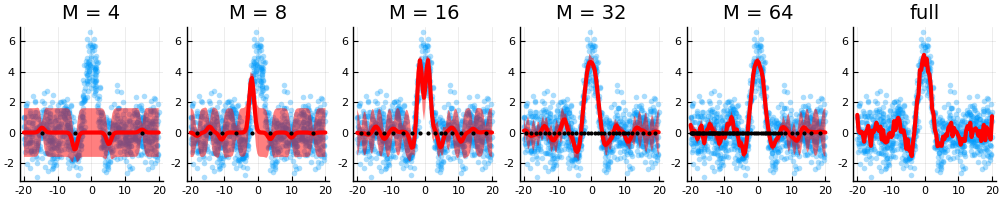

In [20]:
Plots.plot(broadcast(x->plotcontour(x,X,Y),models)...,layout=(1,length(models)),size=(1000,200))